# Customer Churn Prediction Using Machine Learing

Dalam project ini, langkah - langkah yang dilakukan adalah :
1. EDA (Exploratory Data Analysis)
2. Data Pre-Processing
3. Pemodelan Machine Learning
4. Menentukan Model Terbaik


In [1]:
#Importing library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report 
import pickle
from pathlib import Path

## EDA (Exploratory Data Analysis)

In [2]:
#Read the data as pandas data frame
df = pd.read_csv('https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/dqlab_telco_final.csv')

#Returns shape of the data(Row x Column)
print(df.shape)

#Returns the first 5 number of rows
print(df.head())


#Returns the unique customer ID amount
print(df.customerID.nunique())


(6950, 13)
   UpdatedAt   customerID  gender SeniorCitizen Partner  tenure PhoneService  \
0     202006  45759018157  Female            No     Yes       1           No   
1     202006  45315483266    Male            No     Yes      60          Yes   
2     202006  45236961615    Male            No      No       5          Yes   
3     202006  45929827382  Female            No     Yes      72          Yes   
4     202006  45305082233  Female            No     Yes      56          Yes   

  StreamingTV InternetService PaperlessBilling  MonthlyCharges  TotalCharges  \
0          No             Yes              Yes           29.85         29.85   
1          No              No              Yes           20.50       1198.80   
2         Yes             Yes               No          104.10        541.90   
3         Yes             Yes              Yes          115.50       8312.75   
4         Yes             Yes               No           81.25       4620.40   

  Churn  
0    No  
1    No

#### Visualization of Churn Proportions 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

Visualisasikan data secara univariat terkait presentase data churn pelanggan. Hasil visualisasi dapat dilihat dari output kode dibawah ini :

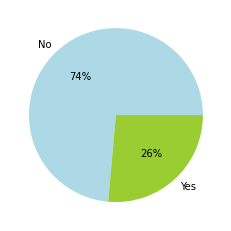

In [4]:
churn = df.Churn.value_counts()

fig, ax = plt.subplots()
colors =['Lightblue','Yellowgreen']
_= ax.pie(churn, labels=churn.index, colors=colors, autopct='%.0f%%')
plt.show()


Dari diagram lingkar diatas, dapat disimpulkan bahwa sebagian besar customer tidak melakukan churn, dengan detail data Churn sebanyak 26% dan No Churn sebanyak 74%.

#### Visualization of Numerical Features Variabel
Visualisasi terhadap variabel predictor yang bersifat numerik secara bivariat.

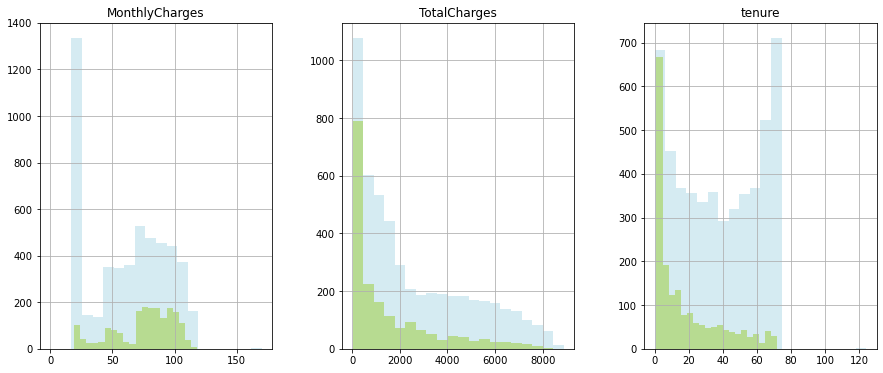

In [5]:
numerical_features = ['MonthlyCharges','TotalCharges','tenure']

fig,ax = plt.subplots(1,3, figsize=(15,6))
df[df.Churn == 'No'][numerical_features].hist(bins=20,color='Lightblue', alpha=0.5, ax=ax)
df[df.Churn == 'Yes'][numerical_features].hist(bins=20,color='Yellowgreen', alpha=0.5, ax=ax)
plt.show()

Numerical features merupakan kolom numerik data frame yang dijadikan variabel prediktor. Berdasarkan histogram diatas dapat disimpulkan bahwa :
- MonthlyCharges: Semakin kecil biaya bulanan maka semakin kecil kecenderungan customer melakukan churn.
- TotalCharges  : Tidak ada kecenderungan apapun terhadap churn
- Tenur         : Semakin lama customer berlangganan maka semakin kecil kecenderungan customer melakukan churn


#### Visualization of Categorical Variabel
Visualisasi terhadap variabel predictor yang bersifat kategorik secara bivariat.

<AxesSubplot:xlabel='PaperlessBilling', ylabel='count'>

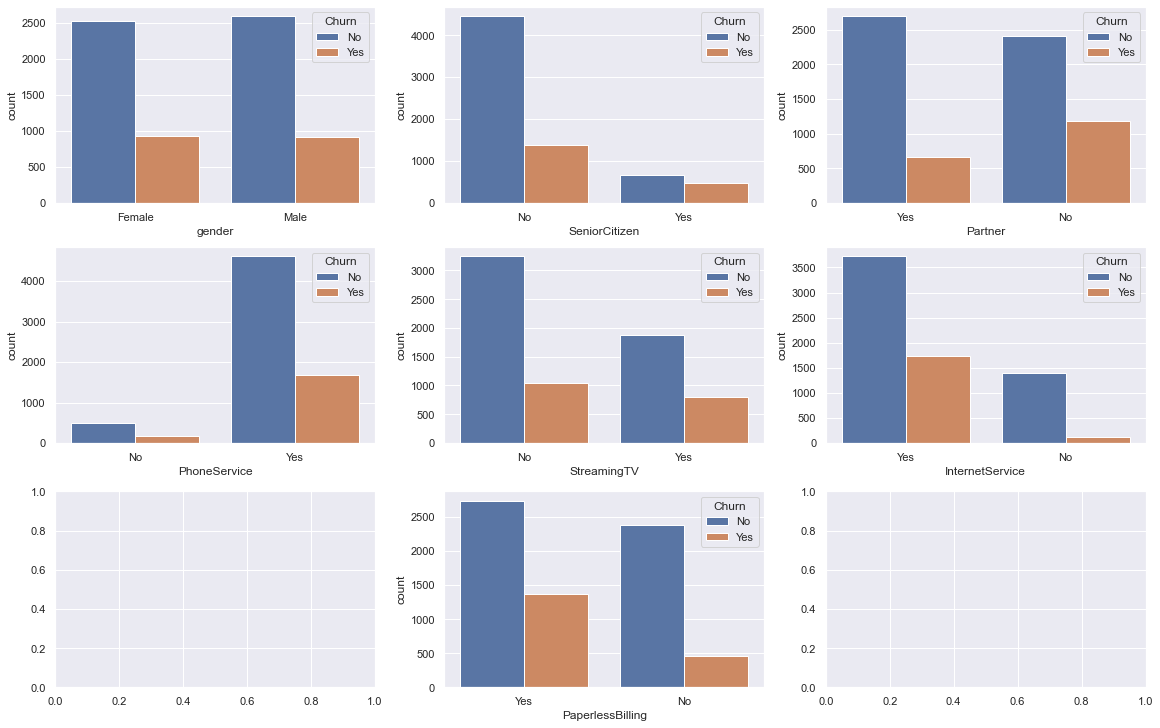

In [6]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(3,3,figsize=(16,10), constrained_layout=True)

sns.countplot(data=df, x='gender', hue='Churn',ax=ax[0][0])
sns.countplot(data=df, x='SeniorCitizen', hue='Churn', ax=ax[0][1])
sns.countplot(data=df, x='Partner', hue='Churn', ax=ax[0][2])
sns.countplot(data=df, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df, x='PaperlessBilling', hue='Churn', ax=ax[2][1])


Dari bar chart diatas dapat disimpulkan bahwa :
- Tidak ada perbedaan yang signifikan terhadap customer yang melakukan churn jika dilihat dari jenis kelamin (gender).
- Terdapat kecenderungan customer yang melakukan churn adalah orang - orang yang statusnya bukan senior citizen (SeniorCitizen: No), orang - orang yang tidak memiliki partner (Partner: No), orang- orang yang memilki layanan telephone (PhoneService: Yes), orang-orang yang tidak mempunyai layanan streaming TV (StreamingTV: No), orang-orang yang mempunyai layanan Internet (InternetService: Yes) dan orang-orang yang tagihannya paperless (PaperlessBilling: Yes). 

## Data Pre-Processing

In [7]:
#Remove unnecessary columns
cleaned_df = df.drop(['customerID','UpdatedAt'], axis=1)
print(cleaned_df.head())


   gender SeniorCitizen Partner  tenure PhoneService StreamingTV  \
0  Female            No     Yes       1           No          No   
1    Male            No     Yes      60          Yes          No   
2    Male            No      No       5          Yes         Yes   
3  Female            No     Yes      72          Yes         Yes   
4  Female            No     Yes      56          Yes         Yes   

  InternetService PaperlessBilling  MonthlyCharges  TotalCharges Churn  
0             Yes              Yes           29.85         29.85    No  
1              No              Yes           20.50       1198.80    No  
2             Yes               No          104.10        541.90   Yes  
3             Yes              Yes          115.50       8312.75    No  
4             Yes               No           81.25       4620.40    No  


#### Encoding Data
Setelah menghapus kolom - kolom yang tidak diperlukan dan menyimpan data terbaru ke dalam variabel cleaned_df, selanjutnya ubahlah nilai dari data yang masih berbentuk string ke dalam bentuk numeic menggunakan LabelEncoder().

In [8]:
from sklearn.preprocessing import LabelEncoder

#Convert all non-numeric columns to numerical data types
for column in cleaned_df.columns :
    if cleaned_df[column].dtype == np.number : continue
        
    cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df.describe())

            gender  SeniorCitizen      Partner       tenure  PhoneService  \
count  6950.000000    6950.000000  6950.000000  6950.000000   6950.000000   
mean      0.504317       0.162302     0.483309    32.415827      0.903741   
std       0.500017       0.368754     0.499757    24.561336      0.294967   
min       0.000000       0.000000     0.000000     0.000000      0.000000   
25%       0.000000       0.000000     0.000000     9.000000      1.000000   
50%       1.000000       0.000000     0.000000    29.000000      1.000000   
75%       1.000000       0.000000     1.000000    55.000000      1.000000   
max       1.000000       1.000000     1.000000    73.000000      1.000000   

       StreamingTV  InternetService  PaperlessBilling  MonthlyCharges  \
count  6950.000000      6950.000000       6950.000000     6950.000000   
mean      0.384317         0.783453          0.591942       64.992201   
std       0.486468         0.411921          0.491509       30.032040   
min       0.00

C:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  """


#### Spliting Dataset
Dataset dibagi menjadi dua bagian untuk keperluan modelling (70% training dan 30% testing)

In [9]:
from sklearn.model_selection import train_test_split

#X as a predictor and y as a target
X = cleaned_df.drop(['Churn'],axis=1)
y = cleaned_df['Churn']

y=y.astype('int')
#Splitting the dataset (70% Training and 30% Testing)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

print('Jumlah baris dan kolom dari X_train :', X_train.shape)
print('Jumlah baris dan kolom dari y_train :', y_train.shape)

print('Persentase Churn di data training adalah :')
print(y_train.value_counts(normalize=True))

print('Jumlah baris dan kolom dari X_test :', X_test.shape)
print('Jumlah baris dan kolom dari y_test :', y_test.shape)

print('Persentase Churn di data testing adalah :')
print(y_test.value_counts(normalize=True))

Jumlah baris dan kolom dari X_train : (4865, 10)
Jumlah baris dan kolom dari y_train : (4865,)
Persentase Churn di data training adalah :
0    0.734841
1    0.265159
Name: Churn, dtype: float64
Jumlah baris dan kolom dari X_test : (2085, 10)
Jumlah baris dan kolom dari y_test : (2085,)
Persentase Churn di data testing adalah :
0    0.738129
1    0.261871
Name: Churn, dtype: float64


## Pemodelan Machine Learning

### Logistic Regression
Menggunakan LogisticRegression() untuk memanggil algoritma tersebut.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#Konfiguration Model
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

##Prediction with Data Training
y_pred = logreg.predict(X_train)

print('Classification Report training model (Logistic Regression) :')
print(classification_report(y_train,y_pred))

Classification Report training model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3575
           1       0.65      0.50      0.56      1290

    accuracy                           0.80      4865
   macro avg       0.74      0.70      0.72      4865
weighted avg       0.79      0.80      0.79      4865



C:\Anaconda\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [11]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

#From Confusion matrix as a DataFrame
cnf_matrix = pd.DataFrame((confusion_matrix(y_train, y_pred)),('No Churn','Churn'), ('No Churn','Churn'))
print('Confusion Matrix : \n', cnf_matrix)


Confusion Matrix : 
           No Churn  Churn
No Churn      3237    338
Churn          650    640


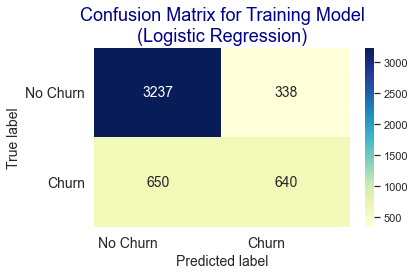

In [12]:
#Plot and Visualization Confusion Matrix
heatmap = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', annot_kws={'size': 14}, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

Hasil dari data training menggunakan algoritma LogisticRegression terlihat bahwa model memiliki akurasi sebesar 80% dengan detail tebakan churn yang sebenarnya benar churn (TP) adalah 640, tebakan tidak churn yang sebenarnya tidak churn (TN) adalah 3237, tebakan tidak churn yang sebenarnya benar churn (FP) adalah 650, dan tebakan churn yang sebenarnya tidak churn (FN) adalah 338.

In [13]:
#Prediction with Data Testing
y_pred = logreg.predict(X_test)

print('Classification Report testing model (Logistic Regression) :')
print(classification_report(y_test,y_pred))

Classification Report testing model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.64      0.48      0.55       546

    accuracy                           0.79      2085
   macro avg       0.74      0.69      0.71      2085
weighted avg       0.78      0.79      0.78      2085



In [14]:
#From Confusion matrix as a DataFrame
cnf_matrix = pd.DataFrame((confusion_matrix(y_test, y_pred)),('No Churn','Churn'), ('No Churn','Churn'))
print('Confusion Matrix : \n', cnf_matrix)

Confusion Matrix : 
           No Churn  Churn
No Churn      1393    146
Churn          282    264


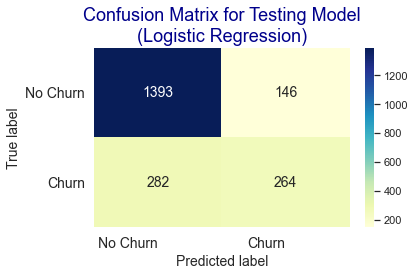

In [15]:
#Plot and Visualization Confusion Matrix
heatmap = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', annot_kws={'size': 14}, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

Hasil dari data testing menggunakan algoritma LogisticRegression terlihat bahwa model memiliki akurasi sebesar 79% dengan detail tebakan churn yang sebenarnya benar churn (TP) adalah 264, tebakan tidak churn yang sebenarnya tidak churn (TN) adalah 1392, tebakan tidak churn yang sebenarnya benar churn (FP) adalah 282, dan tebakan churn yang sebenarnya tidak churn (FN) adalah 146.

### Random Forest Classifier
Gunakan RandomForestClassifier() untuk memanggil algoritma tersebut.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#Konfiguration Model
rf_model =RandomForestClassifier()
rf_model.fit(X_train,y_train)

##Prediction with Data Training
y_pred = rf_model.predict(X_train)

print('Classification Report training model (RandomForestClassifier) :')
print(classification_report(y_train,y_pred))

Classification Report training model (RandomForestClassifier) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       0.99      0.99      0.99      1290

    accuracy                           1.00      4865
   macro avg       0.99      0.99      0.99      4865
weighted avg       1.00      1.00      1.00      4865



In [17]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

#From Confusion matrix as a DataFrame
cnf_matrix = pd.DataFrame((confusion_matrix(y_train, y_pred)),('No Churn','Churn'), ('No Churn','Churn'))
print('Confusion Matrix : \n', cnf_matrix)

Confusion Matrix : 
           No Churn  Churn
No Churn      3565     10
Churn           11   1279


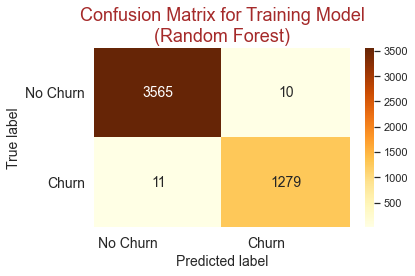

In [18]:
#Plot and Visualization Confusion Matrix
heatmap = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlOrBr', annot_kws={'size': 14}, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)', fontsize=18, color='brown')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

Hasil dari data training menggunakan algoritma Random Forest terlihat bahwa model memiliki akurasi sebesar 100% dengan detail tebakan churn yang sebenarnya benar churn (TP) adalah 1277, tebakan tidak churn yang sebenarnya tidak churn (TN) adalah 3567, tebakan tidak churn yang sebenarnya benar churn (FP) adalah 13, dan tebakan churn yang sebenarnya tidak churn (FN) adalah 8.

In [19]:
#Prediction with Data Testing
y_pred = rf_model.predict(X_test)

print('Classification Report testing model (Random Forest) :')
print(classification_report(y_test,y_pred))

Classification Report testing model (Random Forest) :
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1539
           1       0.59      0.47      0.52       546

    accuracy                           0.78      2085
   macro avg       0.71      0.68      0.69      2085
weighted avg       0.76      0.78      0.77      2085



In [20]:
#From Confusion matrix as a DataFrame
cnf_matrix = pd.DataFrame((confusion_matrix(y_test, y_pred)),('No Churn','Churn'), ('No Churn','Churn'))
print('Confusion Matrix : \n', cnf_matrix)

Confusion Matrix : 
           No Churn  Churn
No Churn      1357    182
Churn          287    259


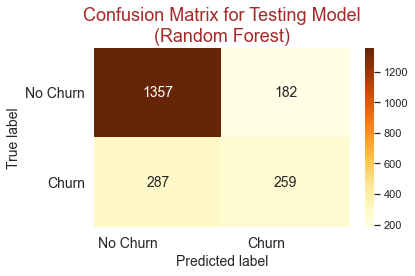

In [21]:
#Plot and Visualization Confusion Matrix
heatmap = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlOrBr', annot_kws={'size': 14}, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Random Forest)', fontsize=18, color='brown')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

Hasil dari data testing menggunakan algoritma Random Forest terlihat bahwa model memiliki akurasi sebesar 79% dengan detail tebakan churn yang sebenarnya benar churn (TP) adalah 264, tebakan tidak churn yang sebenarnya tidak churn (TN) adalah 1393, tebakan tidak churn yang sebenarnya benar churn (FP) adalah 282, dan tebakan churn yang sebenarnya tidak churn (FN) adalah 146.

## Gradient Boosting Classifier
Gunakan GradientBoostingClassifier() untuk memanggil algoritma tersebut.


In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

#Konfiguration Model
gb_model =GradientBoostingClassifier()
gb_model.fit(X_train,y_train)

##Prediction with Data Training
y_pred = gb_model.predict(X_train)

print('Classification Report training model (Gradient Boosting) :')
print(classification_report(y_train,y_pred))

Classification Report training model (Gradient Boosting) :
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3575
           1       0.70      0.53      0.60      1290

    accuracy                           0.82      4865
   macro avg       0.77      0.72      0.74      4865
weighted avg       0.81      0.82      0.81      4865



In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

#From Confusion matrix as a DataFrame
cnf_matrix = pd.DataFrame((confusion_matrix(y_train, y_pred)),('No Churn','Churn'), ('No Churn','Churn'))
print('Confusion Matrix : \n', cnf_matrix)

Confusion Matrix : 
           No Churn  Churn
No Churn      3286    289
Churn          606    684


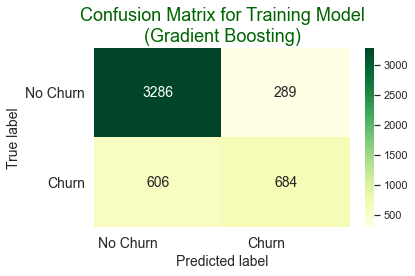

In [24]:
#Plot and Visualization Confusion Matrix
heatmap = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGn', annot_kws={'size': 14}, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Gradient Boosting)', fontsize=18, color='darkgreen')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

Hasil dari data training menggunakan algoritma Gradient Boosting terlihat bahwa model memiliki akurasi sebesar 82% dengan detail tebakan churn yang sebenarnya benar churn (TP) adalah 684, tebakan tidak churn yang sebenarnya tidak churn (TN) adalah 3286, tebakan tidak churn yang sebenarnya benar churn (FP) adalah 606, dan tebakan churn yang sebenarnya tidak churn (FN) adalah 289.

In [25]:
#Prediction with Data Testing
y_pred = gb_model.predict(X_test)

print('Classification Report testing model ((Gradient Boosting) :')
print(classification_report(y_test,y_pred))

Classification Report testing model ((Gradient Boosting) :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.64      0.48      0.55       546

    accuracy                           0.79      2085
   macro avg       0.74      0.69      0.71      2085
weighted avg       0.78      0.79      0.78      2085



In [26]:
#From Confusion matrix as a DataFrame
cnf_matrix = pd.DataFrame((confusion_matrix(y_test, y_pred)),('No Churn','Churn'), ('No Churn','Churn'))
print('Confusion Matrix : \n', cnf_matrix)

Confusion Matrix : 
           No Churn  Churn
No Churn      1395    144
Churn          285    261


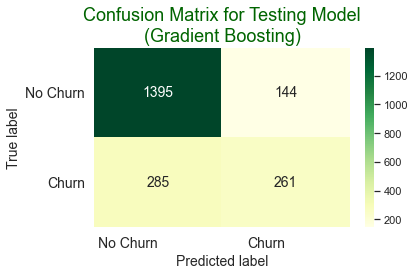

In [27]:
#Plot and Visualization Confusion Matrix
heatmap = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGn', annot_kws={'size': 14}, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Gradient Boosting)', fontsize=18, color='darkgreen')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

Hasil dari data testing menggunakan algoritma Gradient Boosting terlihat bahwa model memiliki akurasi sebesar 79% dengan detail tebakan churn yang sebenarnya benar churn (TP) adalah 261, tebakan tidak churn yang sebenarnya tidak churn (TN) adalah 1394, tebakan tidak churn yang sebenarnya benar churn (FP) adalah 285, dan tebakan churn yang sebenarnya tidak churn (FN) adalah 144.

## Menentukan Model Terbaik

Model terbaik adalah model yang mampu memberikan performa bagus di fase training dan testing model
- Over-Fitting : suatu kondisi dimana model mampu memprediksi dengan sangat baik di fase training, akan tetapi tidak mampu memprediksi sama baiknya di fase testing.
- Under-Fitting : suatu kondisi dimana model kurang mampu memprediksi dengan baik di fase training, akan tetapi mampu memprediksi dengan baik di fase testing.
- Appropriate-Fitting : suatu kondisi dimana model mampu memprediksi dengan baik di fase training maupun di fase testing.

#### Kesimpulan

Berdasarkan hasil keseluruhan pemodelan yang telah dilakukan dengan menggunakan algoritma Logistic Regression, Random Forest dan Extreme Gradiant Boost, dapat disimpulkan bahwa untuk memprediksi churn dari pelanggan dengan menggunakan data set telco, model terbaiknya adalah menggunakan algoritma Logistic Regression. Hal ini karena algoritma Logistic Regression cenderung dapat memprediksi dengan baik pada fase trainng maupun testing, dengan akurasi training 80% dan akurasi testing 79%. Sedangkan model dengan menggunakan algoritma Random Forest dan Extreme Gradiant Boost cenderung bersifat Over-Fitting.